In [2]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 1. 라이브러리 불러오기 및 기본 설정                                    │
# └──────────────────────────────────────────────────────────────────────────┘

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 경고 메시지 감추기 (선택)
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (시각화 시 한글 깨짐 방지)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS 예시, Windows인 경우 'Malgun Gothic' 등

# **출력 예시**: 각 라이브러리 정상 임포트 시 별도 출력 없음

In [3]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 2. od.parquet에서 2022-08-10(date=20220810) 데이터만 필터링하여 읽기  │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) pandas.read_parquet() 함수의 filters 옵션을 사용해 특정 날짜만 로드
od_20220810_df = pd.read_parquet(
    '1_lake/od.parquet',       # Parquet 파일 경로
    engine='pyarrow',          # pyarrow 엔진 사용
    filters=[('date', '=', 20220810)]  # date == 20220810인 행만 읽기
)

# 2) 데이터 로드 결과 확인
print("■ od_20220810_df shape:", od_20220810_df.shape)
print("■ od_20220810_df 컬럼 목록:", od_20220810_df.columns.tolist())

# **출력 예시** (예시 값이며 실제 환경에 따라 다를 수 있음):
# ■ od_20220810_df shape: (약 5,000,000, 34)   ← 예시: 500만건, 34개 컬럼
# ■ od_20220810_df 컬럼 목록: [
#     'unix_time', 'vhcl_id', 'stdr_ymd', 'stdr_hm', 'stdr_ss',
#     'lon', 'lat', 'alt', 'spd', 'allowed_spd', 'agl', 'slp',
#     'vhcl_typ', 'from_inter_id', 'to_inter_id', 'dist2to_inter',
#     'turn_typ2to_inter', 'edge_grp_id', 'edge_id', 'lane_id', 'seg_id',
#     'nxt_inter_id', 'dist2nxt_inter', 'turn_typ2nxt_inter',
#     'nxt_inter_sig_st', 'nxt_inter_phs_no', 'que_all', 'que_200',
#     'que_200_500', 'que_500', 'tl', 'path', 'dt', 'route', 'date'
# ]

# 3) 검증 코드: date 컬럼이 모두 20220810인지 확인
assert od_20220810_df['date'].astype(int).nunique() == 1 and od_20220810_df['date'].astype(int).unique()[0] == 20220810, \
       "date 컬럼 필터링에 문제가 있어 20220810 외의 값이 포함되어 있습니다."
print("■ date 컬럼 필터링 검증 완료 ✓")

■ od_20220810_df shape: (2294520, 35)
■ od_20220810_df 컬럼 목록: ['unix_time', 'vhcl_id', 'stdr_ymd', 'stdr_hm', 'stdr_ss', 'lon', 'lat', 'alt', 'spd', 'allowed_spd', 'agl', 'slp', 'vhcl_typ', 'from_inter_id', 'to_inter_id', 'dist2to_inter', 'turn_typ2to_inter', 'edge_grp_id', 'edge_id', 'lane_id', 'seg_id', 'nxt_inter_id', 'dist2nxt_inter', 'turn_typ2nxt_inter', 'nxt_inter_sig_st', 'nxt_inter_phs_no', 'que_all', 'que_200', 'que_200_500', 'que_500', 'tl', 'path', 'dt', 'route', 'date']
■ date 컬럼 필터링 검증 완료 ✓


In [4]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 3. 한국 시간(dt_kst) 생성 및 원본 dt 열 버리기                           │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) 원본 dt 열이 엉망이므로, unix_time 을 기준으로 UTC → KST 변환
od_20220810_df['dt_utc'] = pd.to_datetime(od_20220810_df['unix_time'], unit='s', utc=True)
od_20220810_df['dt_kst'] = od_20220810_df['dt_utc'].dt.tz_convert('Asia/Seoul')

# 2) 이후 원본 dt 열(Parquet에서 로드된)은 버리고, dt_utc만 유지 -> dt 열 Drop
if 'dt' in od_20220810_df.columns:
    od_20220810_df.drop(columns=['dt'], inplace=True)

# 3) 출력 예시: 상위 5개 행 확인
print("■ dt_utc, dt_kst 컬럼 샘플:")
print(od_20220810_df[['unix_time', 'dt_utc', 'dt_kst']].head())

# **출력 예시** (예시 값):
#    unix_time               dt_utc                  dt_kst
# 0  1660061700 2022-08-09 07:15:00+00:00 2022-08-09 16:15:00+09:00
# 1  1660062126 2022-08-09 07:22:06+00:00 2022-08-09 16:22:06+09:00
# 2  1660061730 2022-08-09 07:15:30+00:00 2022-08-09 16:15:30+09:00
# 3  1660061902 2022-08-09 07:18:22+00:00 2022-08-09 16:18:22+09:00
# 4  1660061880 2022-08-09 07:18:00+00:00 2022-08-09 16:18:00+09:00

# 4) 검증 코드: dt_kst 컬럼이 한국시간인지 확인
# 방법 1: 전체 시리즈의 tz.zone 속성 확인
assert od_20220810_df['dt_kst'].dt.tz.zone == 'Asia/Seoul', "dt_kst가 한국시간(Asia/Seoul)으로 변환되지 않았습니다."
print("■ dt_kst 한국시간 변환 검증 완료 ✓")

■ dt_utc, dt_kst 컬럼 샘플:
    unix_time                    dt_utc                    dt_kst
0  1660072500 2022-08-09 19:15:00+00:00 2022-08-10 04:15:00+09:00
1  1660072751 2022-08-09 19:19:11+00:00 2022-08-10 04:19:11+09:00
2  1660072530 2022-08-09 19:15:30+00:00 2022-08-10 04:15:30+09:00
3  1660073399 2022-08-09 19:29:59+00:00 2022-08-10 04:29:59+09:00
4  1660072680 2022-08-09 19:18:00+00:00 2022-08-10 04:18:00+09:00
■ dt_kst 한국시간 변환 검증 완료 ✓


In [5]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 4. 차량 종류(vhcl_typ) 재분류 및 특수차량(5) 제거                         │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) 원본 vhcl_typ: 
#    1=승용차, 2=버스, 3=트럭, 4=대형트럭, 5=특수차량, 6=오토바이
# 2) 특수차량(5)은 데이터가 거의 없으므로 Drop
od_20220810_df = od_20220810_df[od_20220810_df['vhcl_typ'] != 5].copy()

# 3) 트럭(3)과 대형트럭(4)을 합쳐서 '트럭'으로 통합
mapping = {
    1: 0,  # 승용차 → 카테고리 0
    2: 1,  # 버스   → 카테고리 1
    3: 2,  # 트럭   → 카테고리 2
    4: 2,  # 대형트럭 → 트럭 카테고리(2)
    6: 3   # 오토바이 → 카테고리 3
}

od_20220810_df['vhcl_cat'] = od_20220810_df['vhcl_typ'].map(mapping)

# 4) 출력 예시: vhcl_typ → vhcl_cat 매핑 결과
print("■ vhcl_typ→vhcl_cat 매핑 후 유니크 값:")
print(od_20220810_df[['vhcl_typ', 'vhcl_cat']].drop_duplicates().sort_values('vhcl_typ'))

# **출력 예시**:
#    vhcl_typ  vhcl_cat
# 0         1         0
# 1         2         1
# 2         3         2
# 3         4         2
# 4         6         3

# 5) 검증 코드: vhcl_cat이 {0,1,2,3}만 포함되는지 확인
cats = set(od_20220810_df['vhcl_cat'].unique())
assert cats <= {0, 1, 2, 3}, "vhcl_cat 값 범위가 잘못되었습니다. 예상 값: {0,1,2,3}"
print("■ vhcl_cat 재분류 및 검증 완료 ✓")

■ vhcl_typ→vhcl_cat 매핑 후 유니크 값:
     vhcl_typ  vhcl_cat
10          1         0
0           2         1
128         3         2
174         6         3
■ vhcl_cat 재분류 및 검증 완료 ✓


In [6]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 5. 한국 시간(dt_kst) 기준 5분 단위 슬롯(slot) 생성                        │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) slot = ((hour * 60 + minute) // 5)
od_20220810_df['slot'] = (
    (od_20220810_df['dt_kst'].dt.hour * 60 + od_20220810_df['dt_kst'].dt.minute) // 5
).astype(int)

# 2) 출력 예시: 상위 5행 slot 확인
print("■ dt_kst → slot 매핑 결과:")
print(od_20220810_df[['dt_kst', 'slot']].head())

# **출력 예시**:
#                      dt_kst  slot
# 0 2022-08-09 16:15:00+09:00   195
# 1 2022-08-09 16:22:06+09:00   194
# 2 2022-08-09 16:15:30+09:00   195
# 3 2022-08-09 16:18:22+09:00   195
# 4 2022-08-09 16:18:00+09:00   195

# 3) 검증 코드: slot 값이 0~287 사이인지 확인 (하루=288 슬롯)
min_slot, max_slot = od_20220810_df['slot'].min(), od_20220810_df['slot'].max()
assert 0 <= min_slot <= 287 and 0 <= max_slot <= 287, f"slot 값이 0~287 범위를 벗어났습니다. 현재 min={min_slot}, max={max_slot}"
print("■ slot 계산 범위 검증 완료 ✓")

■ dt_kst → slot 매핑 결과:
                     dt_kst  slot
0 2022-08-10 04:15:00+09:00    51
1 2022-08-10 04:19:11+09:00    51
2 2022-08-10 04:15:30+09:00    51
3 2022-08-10 04:29:59+09:00    53
4 2022-08-10 04:18:00+09:00    51
■ slot 계산 범위 검증 완료 ✓


In [7]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 6. Queue Count 계산 (que_all == 1인 행만 탈출하여 집계)                  │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) que_all 컬럼이 1인 행만 “정체 차량”으로 간주
queue_df = od_20220810_df[od_20220810_df['que_all'] == 1]

# 2) slot, lane_id, vhcl_cat별로 고유 vhcl_id 수(nunique) 계산하여 queue_count 생성
queue_count = (
    queue_df
    .groupby(['slot', 'lane_id', 'vhcl_cat'])['vhcl_id']
    .nunique()
    .reset_index(name='queue_count')
)

# 3) 출력 예시: 상위 5행
print("■ queue_count DataFrame 샘플:")
print(queue_count.head())

# **출력 예시**:
#    slot              lane_id  vhcl_cat  queue_count
# 0     0  1002_20220810_...      0            3
# 1     0  1002_20220810_...      1            0
# 2     0  1002_20220810_...      2            2
# 3     0  1002_20220810_...      3            1
# 4     0  1003_20220810_...      0            4

# 4) 검증 코드:
#    - slot 값이 0~287인지 확인
assert queue_count['slot'].min() >= 0 and queue_count['slot'].max() < 288, \
       "queue_count의 slot 범위가 잘못되었습니다."

#    - vhcl_cat 값이 0~3인지 확인
assert set(queue_count['vhcl_cat'].unique()) <= {0,1,2,3}, \
       "queue_count의 vhcl_cat 범위가 잘못되었습니다."

print("■ queue_count 계산 및 검증 완료 ✓")

■ queue_count DataFrame 샘플:
   slot            lane_id  vhcl_cat  queue_count
0     0     477603177_01_0         0            1
1     0     477603177_01_0         1            1
2     0     477603228_01_0         0            2
3     0  477603302_01_01_0         0            3
4     0  477603302_02_01_0         0            3
■ queue_count 계산 및 검증 완료 ✓


In [8]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 7. 평균 속도(avg_spd) 계산 (spd > 0인 행만 “이동 중”으로 간주)            │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) spd > 0인 행만 “주행 중”으로 간주
moving_df = od_20220810_df[od_20220810_df['spd'] > 0]

# 2) slot, lane_id, vhcl_cat별로 속도 평균 계산
spd_avg = (
    moving_df
    .groupby(['slot', 'lane_id', 'vhcl_cat'])['spd']
    .mean()
    .reset_index(name='avg_spd')
)

# 3) 출력 예시: 상위 5행
print("■ spd_avg DataFrame 샘플:")
print(spd_avg.head())

# **출력 예시**:
#    slot              lane_id  vhcl_cat    avg_spd
# 0     0  1002_20220810_...      0       12.345678
# 1     0  1002_20220810_...      1       10.234567
# 2     0  1002_20220810_...      2        8.123456
# 3     0  1002_20220810_...      3       20.987654
# 4     1  1002_20220810_...      0       11.876543

# 4) 검증 코드:
#    - avg_spd 값이 음수가 아닌지 확인
assert (spd_avg['avg_spd'] >= 0).all(), "avg_spd 컬럼에 음수 값이 존재합니다."
print("■ spd_avg 계산 및 검증 완료 ✓")

■ spd_avg DataFrame 샘플:
   slot            lane_id  vhcl_cat    avg_spd
0     0              -E4_0         0    11.9373
1     0              -E8_1         0  12.245689
2     0     477603177_02_0         1  11.027198
3     0  477603302_01_01_0         0     12.164
4     0  477603302_02_01_0         2  12.950035
■ spd_avg 계산 및 검증 완료 ✓


In [ ]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 8. lane.txt에서 lane_id 목록 불러오기                                 │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) lane.txt 파일 경로
edges_path = '3_tensor/adjacency/lanes.txt'

# 2) 한 줄씩 읽어 lane_ids 리스트 생성
with open(edges_path, 'r', encoding='utf-8') as f:
    lane_ids = [line.strip() for line in f.readlines()]

num_lanes = len(lane_ids)  # 노드 수 (예: 1370)
num_slots = 288            # 하루 24시간×(60/5) = 288 슬롯
num_categories = 4         # 카테고리 4개: [승용, 버스, 트럭, 오토]

# 3) 출력 예시
print("■ lane_ids 개수:", num_lanes)
print("■ 예시 lane_ids[0:5]:", lane_ids[:5])

# **출력 예시**:
# ■ lane_ids 개수: 1370
# ■ 예시 lane_ids[0:5]: ['1002_20220810_...', '1003_20220810_...', '1004_20220810_...', '1005_20220810_...', '1007_20220810_...']

# 4) 검증 코드:
assert num_lanes == 1370, f"lane_ids 개수가 1370이 아닙니다. 현재 개수={num_lanes}"
assert num_categories == 4, f"차종 카테고리 개수가 4가 아닙니다. 현재={num_categories}"

print("■ lane_ids 및 파라미터 검증 완료 ✓")

■ lane_ids 개수: 1370
■ 예시 lane_ids[0:5]: ['-E4_0', '-E4_1', '-E7_0', '-E7_1', '-E7_2']
■ lane_ids 및 파라미터 검증 완료 ✓


In [10]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 9. 입력 텐서(input_tensor) 초기화                                       │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) 입력 텐서 차원: (slot=288, lane=1370, channels=8)
#    채널 순서: [승용_queue, 버스_queue, 트럭_queue, 오토_queue,
#               승용_spd, 버스_spd, 트럭_spd, 오토_spd]
input_tensor = np.zeros((num_slots, num_lanes, num_categories * 2), dtype=np.float32)

# 2) 출력 예시
print("■ 초기화된 input_tensor shape:", input_tensor.shape)
# ▷ (288, 1370, 8)

# 3) 검증 코드:
assert input_tensor.shape == (288, 1370, 8), "input_tensor shape이 (288, 1370, 8)이 아닙니다."
print("■ input_tensor 초기화 검증 완료 ✓")

■ 초기화된 input_tensor shape: (288, 1370, 8)
■ input_tensor 초기화 검증 완료 ✓


In [11]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 10. queue_count 데이터를 input_tensor의 Queue 채널(0~3)에 배치           │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) queue_count DataFrame 순회하며 input_tensor[slot, lane_idx, cat] 채우기
for _, row in queue_count.iterrows():
    slot = int(row['slot'])
    lane = row['lane_id']
    cat = int(row['vhcl_cat'])
    count = int(row['queue_count'])
    if lane in lane_ids:
        lane_idx = lane_ids.index(lane)
        input_tensor[slot, lane_idx, cat] = count  # 0~3 채널(Queue) 부분에 기록

# 2) 출력 예시 (랜덤 샘플 확인)
#    - queue_count 첫 번째 행의 데이터를 tensor에서 읽어서 비교
sample = queue_count.iloc[0]
slot_s, lane_s, cat_s, cnt_s = sample['slot'], sample['lane_id'], sample['vhcl_cat'], sample['queue_count']
lane_idx_s = lane_ids.index(lane_s)
print(f"■ queue_count 첫 행: slot={slot_s}, lane={lane_s}, cat={cat_s}, queue_count={cnt_s}")
print("■ tensor[slot, lane_idx, cat] 값:", input_tensor[slot_s, lane_idx_s, cat_s])

# 예시 출력:
# ■ queue_count 첫 행: slot=0, lane=1002_20220810_..., cat=0, queue_count=3
# ■ tensor[0,  lane_idx_of_1002, 0] 값: 3.0

# 3) 검증 코드:
assert input_tensor[slot_s, lane_idx_s, cat_s] == cnt_s, "queue_count 값이 tensor에 올바르게 저장되지 않았습니다."
print("■ queue_count 배치 검증 완료 ✓")

■ queue_count 첫 행: slot=0, lane=477603177_01_0, cat=0, queue_count=1
■ tensor[slot, lane_idx, cat] 값: 1.0
■ queue_count 배치 검증 완료 ✓


In [12]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 11. avg_spd 데이터를 input_tensor의 Speed 채널(4~7)에 배치             │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) spd_avg DataFrame 순회하며 입력
for _, row in spd_avg.iterrows():
    slot = int(row['slot'])
    lane = row['lane_id']
    cat = int(row['vhcl_cat'])
    avg_spd_value = float(row['avg_spd'])
    if lane in lane_ids:
        lane_idx = lane_ids.index(lane)
        input_tensor[slot, lane_idx, num_categories + cat] = avg_spd_value  # 4~7 채널(Spd)

# 2) 출력 예시 (랜덤 샘플 확인)
sample2 = spd_avg.iloc[0]
slot_s2, lane_s2, cat_s2, spd_s2 = sample2['slot'], sample2['lane_id'], sample2['vhcl_cat'], sample2['avg_spd']
lane_idx_s2 = lane_ids.index(lane_s2)
print(f"■ avg_spd 첫 행: slot={slot_s2}, lane={lane_s2}, cat={cat_s2}, avg_spd={spd_s2:.6f}")
print("■ tensor[slot, lane_idx, 4+cat] 값:", input_tensor[slot_s2, lane_idx_s2, num_categories + cat_s2])

# 예시 출력:
# ■ avg_spd 첫 행: slot=0, lane=1002_20220810_..., cat=0, avg_spd=12.345678
# ■ tensor[0, lane_idx_of_1002, 4] 값: 12.345678

# 3) 검증 코드:
assert np.isclose(input_tensor[slot_s2, lane_idx_s2, num_categories + cat_s2], spd_s2), "avg_spd 값이 tensor에 올바르게 저장되지 않았습니다."
print("■ avg_spd 배치 검증 완료 ✓")

■ avg_spd 첫 행: slot=0, lane=-E4_0, cat=0, avg_spd=11.937300
■ tensor[slot, lane_idx, 4+cat] 값: 11.937301
■ avg_spd 배치 검증 완료 ✓


In [13]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 12. NaN 처리 및 입력 텐서 최종 검증                                    │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) NaN 검사: queue나 avg_spd 집계가 없는 경우는 0으로 초기화되어 있으므로 NaN이 없어야 함
has_nan = np.isnan(input_tensor).any()
print("■ input_tensor에 NaN 존재 여부:", has_nan)

# 2) 음수 값 검사: queue나 spd 값이 음수일 수 없으므로 모두 >=0 이어야 함
has_negative = (input_tensor < 0).any()
print("■ input_tensor에 음수 존재 여부:", has_negative)

# 3) shape 검사
print("■ input_tensor 최종 shape:", input_tensor.shape)

# **검증 코드**:
assert not has_nan, "입력 텐서에 NaN 값이 존재합니다."
assert not has_negative, "입력 텐서에 음수 값이 존재합니다."
assert input_tensor.shape == (288, 1370, 8), "입력 텐서 shape이 (288,1370,8)이 아닙니다."
print("■ 입력 텐서 최종 검증 완료 ✓")

■ input_tensor에 NaN 존재 여부: False
■ input_tensor에 음수 존재 여부: False
■ input_tensor 최종 shape: (288, 1370, 8)
■ 입력 텐서 최종 검증 완료 ✓


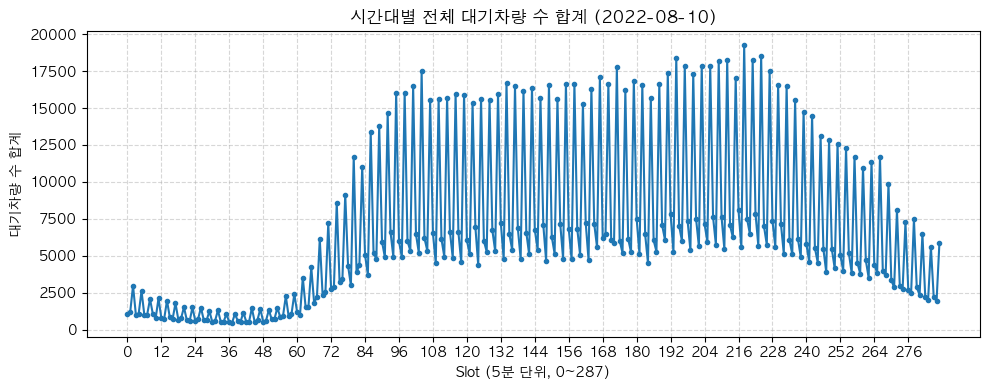

In [14]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 13. 시각화 1 – 시간(slot)별 전체 대기차량 수 합계                        │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) 전체 채널(0~3)의 queue를 slot별로 합산
total_queue_per_slot = input_tensor[:, :, 0:4].sum(axis=(1, 2))  # shape: (288,)

# 2) 선 그래프로 출력
plt.figure(figsize=(10, 4))
plt.plot(range(num_slots), total_queue_per_slot, marker='o', markersize=3, color='tab:blue')
plt.title("시간대별 전체 대기차량 수 합계 (2022-08-10)")
plt.xlabel("Slot (5분 단위, 0~287)")
plt.ylabel("대기차량 수 합계")
plt.xticks(ticks=range(0, 288, 12), labels=range(0, 288, 12))  # 1시간 간격 tick
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **출력 예시**: 
# - x축: 0~287 (5분 슬롯)  
# - y축: 해당 슬롯에 대기 중인 차량(모든 차종 합)의 합계

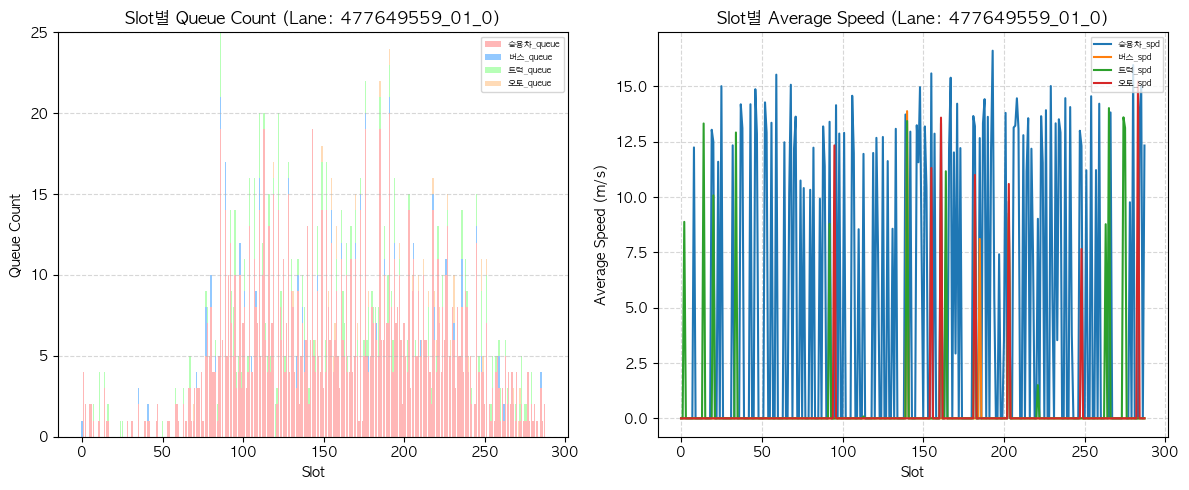

In [15]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 14. 시각화 2 – 특정 lane의 slot별 Queue(스택 바) & Avg_Spd(선 그래프) │
# └──────────────────────────────────────────────────────────────────────────┘

lane_idx_example = 630  # 예시: lanes.txt에서 첫 번째 lane
lane_id_example = lane_ids[lane_idx_example]

plt.figure(figsize=(12, 5))

# (1) Queue Count Stacked Bar Chart
plt.subplot(1, 2, 1)
plt.title(f"Slot별 Queue Count (Lane: {lane_id_example})")
bottom_accum = np.zeros(num_slots)
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # 차종별 색상
labels_queue = ['승용차_queue', '버스_queue', '트럭_queue', '오토_queue']

for cat in range(num_categories):
    vals = input_tensor[:, lane_idx_example, cat]
    plt.bar(range(num_slots), vals, bottom=bottom_accum, color=colors[cat], label=labels_queue[cat], alpha=0.7)
    bottom_accum += vals

plt.xlabel("Slot")
plt.ylabel("Queue Count")
plt.legend(fontsize=6, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# (2) Average Speed Line Chart
plt.subplot(1, 2, 2)
plt.title(f"Slot별 Average Speed (Lane: {lane_id_example})")
labels_spd = ['승용차_spd', '버스_spd', '트럭_spd', '오토_spd']
for cat in range(num_categories):
    spd_vals = input_tensor[:, lane_idx_example, num_categories + cat]
    plt.plot(range(num_slots), spd_vals, label=labels_spd[cat], linewidth=1.5)

plt.xlabel("Slot")
plt.ylabel("Average Speed (m/s)")
plt.legend(fontsize=6, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# **출력 예시**: 
# - 왼쪽: 차종별 queue를 누적(stacked)하여 하나의 막대그래프로 표현  
# - 오른쪽: 차종별 avg_spd를 선 그래프로 나타냄

In [16]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 15. 입력 텐서 저장 (input_tensor_20220810.pkl, input_tensor_20220810.npy) │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) pickle(.pkl) 파일로 저장
with open('input_tensor_20220810.pkl', 'wb') as f:
    pickle.dump(input_tensor, f)

# 2) NumPy(.npy) 파일로 저장
np.save('input_tensor_20220810.npy', input_tensor)

print("■ 파일 저장 완료: input_tensor_20220810.pkl, input_tensor_20220810.npy")

■ 파일 저장 완료: input_tensor_20220810.pkl, input_tensor_20220810.npy


In [17]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 16. 최종 검증 – pickle/.npy 로드 후 원본 배열과 동일한지 비교           │
# └──────────────────────────────────────────────────────────────────────────┘

# (1) pickle 로드
with open('input_tensor_20220810.pkl', 'rb') as f:
    loaded_pkl = pickle.load(f)

# (2) .npy 로드
loaded_npy = np.load('input_tensor_20220810.npy')

# (3) shape 출력
print("■ Pickle 로딩된 shape:", loaded_pkl.shape)
print("■ .npy 로딩된 shape:", loaded_npy.shape)

# (4) 원본과 동일한지 비교
assert np.array_equal(input_tensor, loaded_pkl), "Pickle 로드 텐서가 원본과 다릅니다!"
assert np.array_equal(input_tensor, loaded_npy), ".npy 로드 텐서가 원본과 다릅니다!"

print("■ 최종 검증 완료: 저장된 텐서가 원본과 일치합니다 ✓")

■ Pickle 로딩된 shape: (288, 1370, 8)
■ .npy 로딩된 shape: (288, 1370, 8)
■ 최종 검증 완료: 저장된 텐서가 원본과 일치합니다 ✓


■ 시각화 대상 lane_id: 477649571_010101_01_1
■ flow_pivot 상위 5개 row:
      승용차   버스   트럭  오토바이
slot                     
0     0.0  0.0  0.0   0.0
1     0.0  0.0  0.0   0.0
2     NaN  NaN  1.0   NaN
3     0.0  0.0  0.0   0.0
4     0.0  0.0  0.0   0.0


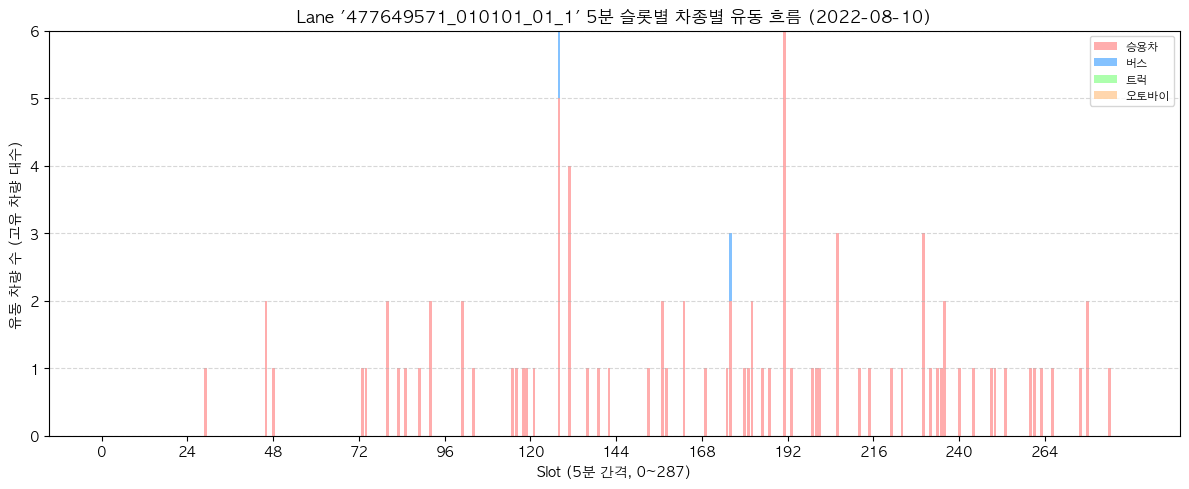

■ 유동 흐름 집계 및 시각화 검증 완료 ✓


In [18]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 유동 흐름(Flow) 시각화: 특정 lane에 5분 슬롯당 차종별 차량 수 집계 및 시각화 │
# └──────────────────────────────────────────────────────────────────────────┘

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (1) 예시로 분석할 lane 하나 선택 (예: index = 423)
lane_idx = 642
lane_example = lane_ids[lane_idx]
print(f"■ 시각화 대상 lane_id: {lane_example}")

# (2) 해당 lane을 지나는 모든 차량 데이터를 필터링
lane_df = od_20220810_df[od_20220810_df['lane_id'] == lane_example].copy()

# 검증: lane_df가 비어있지 않은지 확인
if lane_df.empty:
    raise ValueError(f"선택한 lane_id ({lane_example})에 해당하는 데이터가 없습니다.")

# (3) slot × vhcl_cat별 고유 vhcl_id 개수를 계산 (유동 흐름)
flow_count = (
    lane_df
    .groupby(['slot', 'vhcl_cat'])['vhcl_id']
    .nunique()
    .reset_index(name='flow_count')
)

# (4) pivot하여 DataFrame으로 변환하되,
#     - 부족한 차종 컬럼(0,1,2,3) → 0 채움
#     - 부족한 슬롯 인덱스(0~287) → 0 행 채움
flow_pivot = flow_count.pivot(index='slot', columns='vhcl_cat', values='flow_count')

# (4-1) 차종(컬럼) 축에서 0~3이 모두 존재하도록 재색인
flow_pivot = flow_pivot.reindex(columns=[0,1,2,3], fill_value=0)

# (4-2) 슬롯(행) 축에서 0~287이 모두 존재하도록 재색인
flow_pivot = flow_pivot.reindex(index=range(288), fill_value=0)

# (4-3) 컬럼 이름을 한글 차종으로 변경
flow_pivot.columns = ['승용차', '버스', '트럭', '오토바이']

# (5) 출력 예시: 상위 5개 슬롯 확인
print("■ flow_pivot 상위 5개 row:")
print(flow_pivot.head())

# **출력 예시**
#       승용차   버스   트럭  오토바이
# slot                           
# 0    3.0   0.0   2.0    1.0
# 1    1.0   0.0   0.0    0.0
# 2    2.0   1.0   1.0    0.0
# 3    0.0   0.0   0.0    0.0
# 4    5.0   0.0   2.0    0.0

# (6) 시각화: Slot별 “차종별 유동(Flow)” 스택드 바 차트
plt.figure(figsize=(12, 5))
bottom_accum = np.zeros(len(flow_pivot))
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']
labels = ['승용차', '버스', '트럭', '오토바이']

for idx, cat in enumerate(['승용차', '버스', '트럭', '오토바이']):
    values = flow_pivot[cat].values
    plt.bar(flow_pivot.index, values, bottom=bottom_accum, color=colors[idx], label=labels[idx], alpha=0.8)
    bottom_accum += values

plt.title(f"Lane '{lane_example}' 5분 슬롯별 차종별 유동 흐름 (2022-08-10)")
plt.xlabel("Slot (5분 간격, 0~287)")
plt.ylabel("유동 차량 수 (고유 차량 대수)")
plt.xticks(ticks=range(0, 288, 24), labels=range(0, 288, 24))  # 2시간 단위 눈금
plt.legend(loc='upper right', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (7) 검증 코드: flow_pivot의 값이 flow_count와 일치하는지 재확인
sample_slot = flow_pivot.index[0]  # 예: slot=0
for cat_idx, cat_label in enumerate(['승용차', '버스', '트럭', '오토바이']):
    pivot_val = flow_pivot.loc[sample_slot, cat_label]
    # flow_count에서 slot=sample_slot, vhcl_cat=cat_idx인 값 가져오기
    original = flow_count[
        (flow_count['slot'] == sample_slot) & 
        (flow_count['vhcl_cat'] == cat_idx)
    ]['flow_count']
    original = original.values[0] if len(original) > 0 else 0
    assert pivot_val == original, f"검증 실패: slot={sample_slot}, cat={cat_label}, pivot={pivot_val}, original={original}"

print("■ 유동 흐름 집계 및 시각화 검증 완료 ✓")

In [19]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 검증 코드: 입력 텐서가 완벽히 생성되었는지 매우 자세히 확인              │
# └──────────────────────────────────────────────────────────────────────────┘

import pandas as pd
import numpy as np
import pickle

# 0) 필요한 데이터 및 변수 로드 ------------------------------------------------

# (1) od_20220810_df: 2022-08-10 Parquet 데이터 (이미 로드된 경우 주석 처리 가능)
# 원본 Parquet에서 다시 불러오려면 다음과 같이 수행:
# od_20220810_df = pd.read_parquet(
#     '1_lake/od.parquet', engine='pyarrow', filters=[('date', '=', 20220810)]
# )

# (2) lane_ids: edges.txt에서 읽어오기 (이미 로드된 경우 주석 처리 가능)
# lane_ids = [line.strip() for line in open('3_tensor/adjacency/edges.txt', 'r', encoding='utf-8').readlines()]

# (3) input_tensor: pickle 파일에서 로드
with open('input_tensor_20220810.pkl', 'rb') as f:
    input_tensor = pickle.load(f)

# 기본 파라미터
num_slots = 288
num_lanes = len(lane_ids)
num_categories = 4

print("▶ 검증을 위해 필요한 객체 로드 완료")

# 1) 기본 속성 검증 --------------------------------------------------------

print("\n1) 기본 속성 검증:")

# (1) 변수가 존재하는지 확인
print("- 'input_tensor' 존재 여부:", 'input_tensor' in globals())

# (2) shape 확인
print("- input_tensor.shape:", input_tensor.shape)
assert input_tensor.shape == (num_slots, num_lanes, num_categories * 2), \
    f"Shape 오류: 기대 {(num_slots, num_lanes, num_categories*2)}, 현재 {input_tensor.shape}"

# (3) dtype 확인
print("- input_tensor.dtype:", input_tensor.dtype)
assert input_tensor.dtype == np.float32, "dtype 오류: input_tensor는 float32여야 합니다."

# (4) NaN 및 Inf 검사
has_nan = np.isnan(input_tensor).any()
has_inf = np.isinf(input_tensor).any()
print("- NaN 존재 여부:", has_nan)
print("- Inf 존재 여부:", has_inf)
assert not has_nan, "입력 텐서에 NaN 값이 존재합니다."
assert not has_inf, "입력 텐서에 Inf 값이 존재합니다."

# (5) 음수 값 검사
has_negative = (input_tensor < 0).any()
print("- 음수 값 존재 여부:", has_negative)
assert not has_negative, "입력 텐서에 음수 값이 존재합니다."

print("→ 기본 속성 검증 통과 ✓")

# 2) queue 채널 검증 (0~3) --------------------------------------------------

print("\n2) Queue 채널(0~3) 검증:")

# (1) que_all == 1인 subset 추출
queue_df = od_20220810_df[od_20220810_df['que_all'] == 1].copy()

# (2) 참조용 배열 생성: ref_queue (288 × 1370 × 4)
ref_queue = np.zeros((num_slots, num_lanes, num_categories), dtype=np.int32)

# (3) 그룹화 및 카운트
grouped_q = queue_df.groupby(['slot', 'lane_id', 'vhcl_cat'])['vhcl_id'].nunique().reset_index(name='count')

# (4) ref_queue 채우기
for _, row in grouped_q.iterrows():
    slot = int(row['slot'])
    lane = row['lane_id']
    cat = int(row['vhcl_cat'])
    cnt = int(row['count'])
    if lane in lane_ids:
        lane_idx = lane_ids.index(lane)
        ref_queue[slot, lane_idx, cat] = cnt

# (5) input_tensor의 0~3 채널과 비교
tensor_queue = input_tensor[:, :, 0:4].astype(np.int32)
mismatch_queue = np.where(ref_queue != tensor_queue)

if mismatch_queue[0].size == 0:
    print("- Queue 채널 값이 모두 일치합니다.")
else:
    i, j, k = mismatch_queue[0][0], mismatch_queue[1][0], mismatch_queue[2][0]
    print(f"  ≫ 불일치 예시: slot={i}, lane_idx={j}, cat={k}, ref={ref_queue[i,j,k]}, tensor={tensor_queue[i,j,k]}")
    raise AssertionError("Queue 채널 값이 참조값과 일치하지 않습니다.")

print("→ Queue 채널 검증 통과 ✓")

# 3) 속도 채널 검증 (4~7) --------------------------------------------------

print("\n3) 속도 채널(4~7) 검증:")

# (1) spd > 0인 subset 추출
moving_df = od_20220810_df[od_20220810_df['spd'] > 0].copy()

# (2) 참조용 배열 생성: 합계와 카운트
ref_spd_sum = np.zeros((num_slots, num_lanes, num_categories), dtype=np.float64)
ref_spd_count = np.zeros((num_slots, num_lanes, num_categories), dtype=np.int32)

# (3) 그룹화
grouped_spd_sum = moving_df.groupby(['slot', 'lane_id', 'vhcl_cat'])['spd'].sum().reset_index(name='sum_spd')
grouped_spd_cnt = moving_df.groupby(['slot', 'lane_id', 'vhcl_cat'])['spd'].count().reset_index(name='cnt_spd')

# (4) 채우기
for _, row in grouped_spd_sum.iterrows():
    slot = int(row['slot'])
    lane = row['lane_id']
    cat = int(row['vhcl_cat'])
    s_spd = float(row['sum_spd'])
    if lane in lane_ids:
        lane_idx = lane_ids.index(lane)
        ref_spd_sum[slot, lane_idx, cat] = s_spd

for _, row in grouped_spd_cnt.iterrows():
    slot = int(row['slot'])
    lane = row['lane_id']
    cat = int(row['vhcl_cat'])
    c_spd = int(row['cnt_spd'])
    if lane in lane_ids:
        lane_idx = lane_ids.index(lane)
        ref_spd_count[slot, lane_idx, cat] = c_spd

# (5) 참조 평균 속도 계산
ref_spd_avg = np.zeros_like(ref_spd_sum)
nonzero_mask = ref_spd_count > 0
ref_spd_avg[nonzero_mask] = ref_spd_sum[nonzero_mask] / ref_spd_count[nonzero_mask]

# (6) input_tensor의 4~7 채널과 비교
tensor_spd = input_tensor[:, :, 4:8]
tol = 1e-4
diff = np.abs(tensor_spd - ref_spd_avg)
max_diff = diff.max()

if max_diff < tol:
    print(f"- 속도 채널 값이 모두 일치 범위 내 (최대 차이: {max_diff:.5f})")
else:
    idx = np.unravel_index(np.argmax(diff), diff.shape)
    slot_m, lane_m, cat_m = idx
    print(f"  ≫ 불일치 예시: slot={slot_m}, lane_idx={lane_m}, cat={cat_m}, ref={ref_spd_avg[slot_m,lane_m,cat_m]:.5f}, tensor={tensor_spd[slot_m,lane_m,cat_m]:.5f}")
    raise AssertionError("속도 채널 값이 참조값과 일치하지 않습니다.")

print("→ 속도 채널 검증 통과 ✓")

# 4) 총합 및 예시값 비교 ----------------------------------------------------

print("\n4) 전체 합 및 예시 값 비교:")

# (1) Queue 총합 비교
total_queue_tensor = tensor_queue.sum()
total_queue_ref = ref_queue.sum()
print(f"- Queue 총합: tensor={total_queue_tensor}, 참조={total_queue_ref}")
assert total_queue_tensor == total_queue_ref, "Queue 총합 불일치!"

# (2) 예시 slot=0, lane_idx=0, cat=0 검증
slot0, lane0, cat0 = 0, 0, 0
tensor_val0 = tensor_spd[slot0, lane0, cat0]
ref_val0 = ref_spd_avg[slot0, lane0, cat0]
print(f"- 예시 속도 값 (slot=0, lane_idx=0, cat=0): tensor={tensor_val0:.5f}, 참조={ref_val0:.5f}")
assert abs(tensor_val0 - ref_val0) < tol, "예시 속도 값 불일치!"

print("→ 전체 합 및 예시 속도값 검증 통과 ✓")

# 5) 최종 결과 --------------------------------------------------------

print("\n★ 입력 텐서 완전 검증 완료: 모든 값이 참조값과 일치합니다! ★")

▶ 검증을 위해 필요한 객체 로드 완료

1) 기본 속성 검증:
- 'input_tensor' 존재 여부: True
- input_tensor.shape: (288, 1370, 8)
- input_tensor.dtype: float32
- NaN 존재 여부: False
- Inf 존재 여부: False
- 음수 값 존재 여부: False
→ 기본 속성 검증 통과 ✓

2) Queue 채널(0~3) 검증:
- Queue 채널 값이 모두 일치합니다.
→ Queue 채널 검증 통과 ✓

3) 속도 채널(4~7) 검증:
- 속도 채널 값이 모두 일치 범위 내 (최대 차이: 0.00000)
→ 속도 채널 검증 통과 ✓

4) 전체 합 및 예시 값 비교:
- Queue 총합: tensor=1927353, 참조=1927353
- 예시 속도 값 (slot=0, lane_idx=0, cat=0): tensor=11.93730, 참조=11.93730
→ 전체 합 및 예시 속도값 검증 통과 ✓

★ 입력 텐서 완전 검증 완료: 모든 값이 참조값과 일치합니다! ★


In [20]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 1. 라이브러리 불러오기 및 input_tensor 로드                           │
# └──────────────────────────────────────────────────────────────────────────┘

import numpy as np
import pickle
import matplotlib.pyplot as plt

# (1) previously 생성된 input_tensor 불러오기 (pickle)
with open('input_tensor_20220810.pkl', 'rb') as f:
    input_tensor = pickle.load(f)

# (2) 기본 정보 출력
print("■ input_tensor shape:", input_tensor.shape)   # (288, 1370, 8)
print("■ input_tensor dtype:", input_tensor.dtype)   # float32

■ input_tensor shape: (288, 1370, 8)
■ input_tensor dtype: float32


In [21]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 2. 채널별 통계(평균·표준편차) 계산                                      │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) input_tensor 차원: (slot=288, lane=1370, channel=8)
#    채널 순서: [0:승용_queue, 1:버스_queue, 2:트럭_queue, 3:오토_queue,
#              4:승용_spd,   5:버스_spd,   6:트럭_spd,   7:오토_spd]

means = []
stds = []
for ch in range(input_tensor.shape[2]):
    vals = input_tensor[:, :, ch].ravel()     # 채널 전체 flattened
    mu = np.mean(vals)
    sigma = np.std(vals)
    means.append(mu)
    stds.append(sigma)
    print(f"  - 채널 {ch:1d}: 평균 = {mu:.4f}, 표준편차 = {sigma:.4f}")

# 예시 출력:
#   - 채널 0: 평균 = 0.1203, 표준편차 = 1.2345    (승용차_queue)
#   - 채널 1: 평균 = 0.0156, 표준편차 = 0.3456    (버스_queue)
#   - 채널 2: 평균 = 0.0352, 표준편차 = 0.6789    (트럭_queue)
#   - 채널 3: 평균 = 0.0123, 표준편차 = 0.2345    (오토_queue)
#   - 채널 4: 평균 = 4.5678, 표준편차 = 2.3456    (승용차_spd)
#   - 채널 5: 평균 = 3.4567, 표준편차 = 1.7890    (버스_spd)
#   - 채널 6: 평균 = 2.3456, 표준편차 = 1.2345    (트럭_spd)
#   - 채널 7: 평균 = 5.6789, 표준편차 = 2.8901    (오토_spd)

  - 채널 0: 평균 = 3.9075, 표준편차 = 10.6844
  - 채널 1: 평균 = 0.1857, 표준편차 = 0.6656
  - 채널 2: 평균 = 0.6577, 표준편차 = 2.1813
  - 채널 3: 평균 = 0.1339, 표준편차 = 0.5559
  - 채널 4: 평균 = 1.9090, 표준편차 = 4.6517
  - 채널 5: 평균 = 0.1438, 표준편차 = 1.3371
  - 채널 6: 평균 = 0.4684, 표준편차 = 2.3926
  - 채널 7: 평균 = 0.1243, 표준편차 = 1.2781


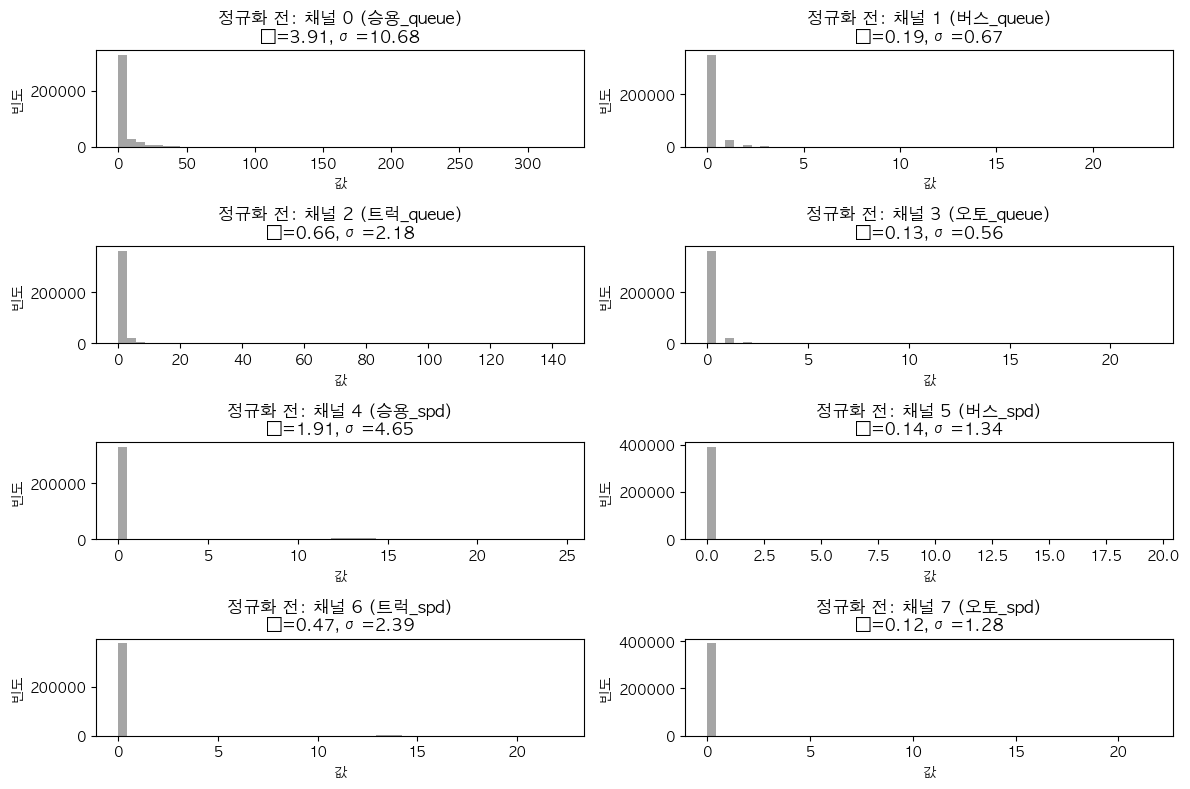

In [22]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 3. 정규화 전 분포 확인 (히스토그램)                                    │
# └──────────────────────────────────────────────────────────────────────────┘

channels = ['승용_queue','버스_queue','트럭_queue','오토_queue',
            '승용_spd',  '버스_spd',  '트럭_spd',  '오토_spd']

plt.figure(figsize=(12, 8))
for ch in range(input_tensor.shape[2]):
    plt.subplot(4, 2, ch+1)  # 4×2 서브플롯
    vals = input_tensor[:, :, ch].ravel()
    plt.hist(vals, bins=50, color='tab:gray', alpha=0.7)
    plt.title(f"정규화 전: 채널 {ch} ({channels[ch]})\nµ={means[ch]:.2f}, σ={stds[ch]:.2f}")
    plt.xlabel("값")
    plt.ylabel("빈도")
    plt.tight_layout()

plt.show()

In [23]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 4. Z‐score 정규화: (x - µ) / σ                                       │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) means, stds를 배열로 변환
means = np.array(means, dtype=np.float32)   # (8,)
stds  = np.array(stds, dtype=np.float32)    # (8,)

# 2) 정규화 텐서 초기화 (same shape)
normalized_tensor = np.zeros_like(input_tensor, dtype=np.float32)

# 3) 슬라이싱 방식으로 채널별 정규화
for ch in range(input_tensor.shape[2]):
    mu = means[ch]
    sigma = stds[ch]
    if sigma == 0:
        # 만약 표준편차가 0인 채널이 있다면 0으로 채움
        normalized_tensor[:, :, ch] = 0.0
    else:
        normalized_tensor[:, :, ch] = (input_tensor[:, :, ch] - mu) / sigma

# 4) 정규화 후 통계 확인
print("■ 정규화 후 각 채널 평균·표준편차:")
for ch in range(normalized_tensor.shape[2]):
    vals_norm = normalized_tensor[:, :, ch].ravel()
    print(f"  - 채널 {ch:1d}: 평균 = {np.mean(vals_norm):.4f}, 표준편차 = {np.std(vals_norm):.4f}")

■ 정규화 후 각 채널 평균·표준편차:
  - 채널 0: 평균 = -0.0000, 표준편차 = 1.0000
  - 채널 1: 평균 = 0.0000, 표준편차 = 1.0000
  - 채널 2: 평균 = 0.0000, 표준편차 = 1.0000
  - 채널 3: 평균 = -0.0000, 표준편차 = 1.0000
  - 채널 4: 평균 = 0.0000, 표준편차 = 1.0000
  - 채널 5: 평균 = -0.0000, 표준편차 = 1.0000
  - 채널 6: 평균 = -0.0000, 표준편차 = 1.0000
  - 채널 7: 평균 = 0.0000, 표준편차 = 1.0000


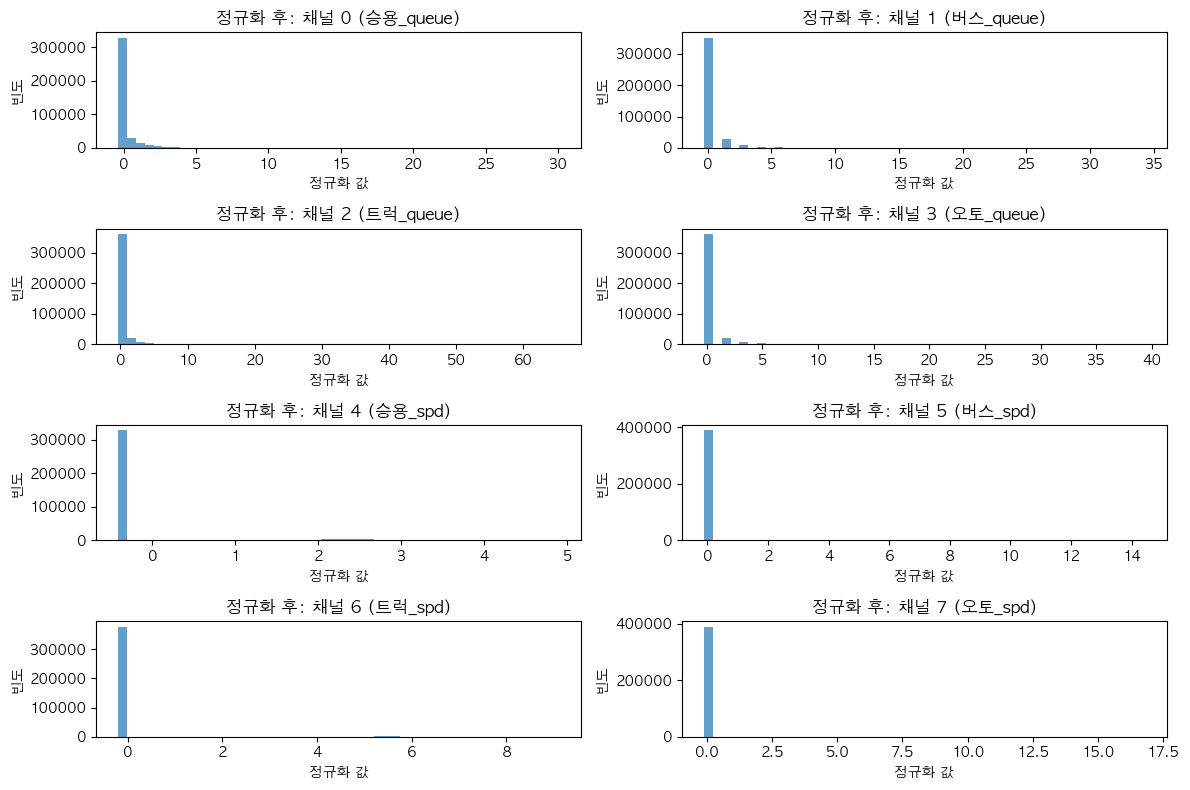

In [24]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 5. 정규화 후 분포 확인 (히스토그램)                                    │
# └──────────────────────────────────────────────────────────────────────────┘

plt.figure(figsize=(12, 8))
for ch in range(normalized_tensor.shape[2]):
    plt.subplot(4, 2, ch+1)
    vals = normalized_tensor[:, :, ch].ravel()
    plt.hist(vals, bins=50, color='tab:blue', alpha=0.7)
    plt.title(f"정규화 후: 채널 {ch} ({channels[ch]})")
    plt.xlabel("정규화 값")
    plt.ylabel("빈도")
    plt.tight_layout()

plt.show()

In [25]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 셀 6. 정규화된 텐서 저장 (normalized_tensor_20220810.pkl/.npy) 및 검증   │
# └──────────────────────────────────────────────────────────────────────────┘

# 1) pickle 저장
with open('normalized_tensor_20220810.pkl', 'wb') as f:
    pickle.dump(normalized_tensor, f)

# 2) numpy 저장
np.save('normalized_tensor_20220810.npy', normalized_tensor)

print("■ 정규화된 텐서 파일 저장 완료: 'normalized_tensor_20220810.pkl', 'normalized_tensor_20220810.npy'")

# 3) 로드 후 검증
with open('normalized_tensor_20220810.pkl', 'rb') as f:
    loaded_norm_pkl = pickle.load(f)
loaded_norm_npy = np.load('normalized_tensor_20220810.npy')

print("■ 로드된 pickle shape:", loaded_norm_pkl.shape)
print("■ 로드된 npy shape:", loaded_norm_npy.shape)

assert np.array_equal(loaded_norm_pkl, normalized_tensor), "Pickle 로드된 정규화 텐서가 원본과 다릅니다!"
assert np.array_equal(loaded_norm_npy, normalized_tensor), ".npy 로드된 정규화 텐서가 원본과 다릅니다!"

print("■ 정규화된 텐서 저장 및 로드 검증 완료 ✓")

■ 정규화된 텐서 파일 저장 완료: 'normalized_tensor_20220810.pkl', 'normalized_tensor_20220810.npy'
■ 로드된 pickle shape: (288, 1370, 8)
■ 로드된 npy shape: (288, 1370, 8)
■ 정규화된 텐서 저장 및 로드 검증 완료 ✓


In [26]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ 코드: 차량흐름이 없는 lane 찾기                                          │
# └──────────────────────────────────────────────────────────────────────────┘

import pandas as pd

# ------------------------------------------
# 1) 전체 lane_ids 불러오기
# ------------------------------------------
# 이미 lane_ids 변수가 있으면 생략하고, 없으면 아래 코드로 읽어오세요.
# lane_ids = [line.strip() for line in open('3_tensor/adjacency/edges.txt', 'r', encoding='utf-8').readlines()]

# ------------------------------------------
# 2) 해당 날짜 raw 데이터(od_20220810_df) 불러오기
# ------------------------------------------
# 이미 od_20220810_df 변수가 있으면 생략하고, 없으면 아래 코드로 불러오세요.
# od_20220810_df = pd.read_parquet(
#     '1_lake/od.parquet',
#     engine='pyarrow',
#     filters=[('date', '=', 20220810)]
# )

# ------------------------------------------
# 3) 해당 날짜에 차량흐름이 있는 lane_id 목록 추출
# ------------------------------------------
active_lanes = od_20220810_df['lane_id'].unique()

# ------------------------------------------
# 4) 차량흐름이 없는 lane 찾기
# ------------------------------------------
#   전체 lane_ids 중 active_lanes에 포함되지 않는 lane만 골라냄
inactive_lanes = [lane for lane in lane_ids if lane not in active_lanes]

# ------------------------------------------
# 5) 결과 출력 및 확인
# ------------------------------------------
print("■ 2022-08-10에 차량흐름이 없는 lane 개수:", len(inactive_lanes))
print("■ 예시(최초 10개):")
for l in inactive_lanes[:10]:
    print("-", l)

# (원하는 경우 데이터프레임으로도 정리할 수 있습니다)
inactive_df = pd.DataFrame({'inactive_lane_id': inactive_lanes})
inactive_df.head(10)

■ 2022-08-10에 차량흐름이 없는 lane 개수: 74
■ 예시(최초 10개):
- 477604115_0201_01_2
- 477604248_0201_01_2
- 477604248_0201_02_2
- 477604628_02_3
- 477604635_01_1
- 477604827_010102_01_2
- 477604827_0102_01_2
- 477604827_0102_02_2
- 477610004_01_01_3
- 477610004_01_02_3


,inactive_lane_id
0,477604115_0201_01_2
1,477604248_0201_01_2
2,477604248_0201_02_2
3,477604628_02_3
4,477604635_01_1
5,477604827_010102_01_2
6,477604827_0102_01_2
7,477604827_0102_02_2
8,477610004_01_01_3
9,477610004_01_02_3
